# Entrega 4: Variação paramétrica

Nesse notebook/relatório iremos realizar e justificar o processo em cada etapa da experimentação com modelos de classificação seguindo o conteúdo aprendido ao longo da disciplina. Nos baseamos nos notebooks fornecidos pelo professor ao longo das aulas. 

**Disclaimer**: Vale ressaltar que, pela natureza do dataset, a classificação que mais faz sentido de ser feita é a entre o gênero dos usuários. Entretando, de nenhuma maneira os participantes desse grupo concordam com a visão de que seria ético delimitar um padrão de usuário baseado apenas em gênero e a ferramenta que estaremos criando aqui não deve ser usada para prejudicar a equidade entre pessoas de diferentes gêneros.

### Grupo
 - Nilo Bemfica (nbmcd)
 - Pedro Didier (pdm)
 - Pedro Tenório (ptl)

# Importando bibliotecas

In [1]:
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')

c:\Users\Pedro\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Preparando ambiente de experimentos

Definindo uma seed para reprodutibilidade do experimento

In [2]:
seed_value= 42
# Fixando a seed para reprodutibilidade dos experimentos
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Carregamento dos dados tratados

In [3]:
df = pd.read_csv("homologated_data.csv")

## Adaptando inputs para experimentos com Machine Learning
Vamos fazer as seguintes adaptações finais:
 - Manter apenas a coluna de gender como target, removendo os 'unknown' (label 0). Não faz sentido fazer uma classificação de gênero com usuários que não declararam seu gênero ou preferiram não responder.

In [4]:
df = df.drop(columns=["C_man", "C_api"])
df = df[df["gender"] != 0].reset_index(drop=True)

 - Transformar as colunas de datetime em colunas numéricas, contando a partir do dia inicial como dia 0

In [5]:
# Função para transformar tempo em um valor inteiro, preservando semantica
def time_to_int(date_str):
    date = pd.to_datetime(date_str)

    total = int(date.strftime('%S'))
    total += int(date.strftime('%M')) * 60
    total += int(date.strftime('%H')) * 60 * 60
    total += (int(date.strftime('%j')) - 1) * 60 * 60 * 24
    # 2002 é o ano mais antigo no dataset
    total += (int(date.strftime('%Y')) - 2002) * 60 * 60 * 24 * 365
    return total

df["firstDay"] = df["firstDay"].apply(time_to_int)
df["lastDay"] = df["lastDay"].apply(time_to_int)

## Train-test split

In [6]:
df.columns

Index(['gender', 'E_NEds', 'E_Bpag', 'firstDay', 'lastDay', 'NEds', 'NDays',
       'NActDays', 'NPages', 'NPcreated', 'pagesWomen', 'wikiprojWomen',
       'ns_user', 'ns_wikipedia', 'ns_talk', 'ns_userTalk', 'ns_content',
       'weightIJ', 'NIJ'],
      dtype='object')

Vamos definir nossa label (coluna gender) e as nossas features (demais colunas)

In [7]:
X = df.drop(columns=["gender"]).values
y = df["gender"].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=seed_value
)

Também vamos utilizar crossvalidation para nossa experimentação. Escolhemos o algoritmo k-fold com popular valor de k=10.

In [9]:
cv = model_selection.StratifiedKFold(n_splits=10)

# Modelagem e Otimização de Parâmetros

Seguindo uma das estratégias apresentadas em aula, vamos experimentar com três algoritmos bastante utilizados para dados tabulares no sklearn. São eles:
 - Random Forest (RF)
 - Support Vector Classification (SVC)
 - Multi Layer Perceptron (MLP)

In [10]:
rfc = RandomForestClassifier()
svc = SVC()
mlp = MLPClassifier()

A seleção dos hiperparâmetros para cada modelo foi baseada na consideração de combinações que abrangem uma variedade de comportamentos do modelo, permitindo uma otimização adequada e robusta:

- RandomForest (RF):  
        - n_estimators: Os valores variam de árvores menores (10) a mais numerosas (200), explorando a capacidade do modelo de aprender com um conjunto diversificado de árvores.  
        - max_depth: A variação inclui árvores mais rasas e mais profundas, bem como a opção de deixar a árvore crescer até que todas as folhas sejam puras (None).  
        - min_samples_split e min_samples_leaf: Estes parâmetros ajudam a controlar o overfitting. Variam desde configurações que permitem divisões mais flexíveis até aquelas que requerem   mais amostras para divisões e folhas.  
        - bootstrap: Com ambas as opções (True e False), estamos explorando tanto a amostragem com reposição quanto sem reposição.

- Support Vector Classification (SVC):  
        -C: Este é o parâmetro de regularização. Valores menores implicam em mais regularização e valores maiores em menos. Estamos explorando desde uma regularização alta (0.1) até baixa (10).  
        - gamma: Controla a forma do limite de decisão. Os valores variam desde um limite mais flexível (1) até um mais rígido (0.001).  
        - kernel: Apenas o 'rbf' foi escolhido, que é o kernel Radial Basis Function, comum e eficaz para muitos problemas.

- Multi-Layer Perceptron (MLP):  
        - hidden_layer_sizes: Exploramos redes desde uma única camada oculta até duas camadas, com diferentes quantidades de neurônios, para capturar diferentes capacidades de modelagem.  
        - activation: Diferentes funções de ativação podem influenciar o comportamento e a convergência da rede.  
        - solver: Diferentes solucionadores podem ter desempenho variável dependendo da natureza dos dados e da arquitetura da rede.  
        - alpha: Controla a regularização L2, e estamos explorando desde uma regularização fraca até uma mais forte.  
        - learning_rate: Diferentes estratégias de taxa de aprendizado podem afetar a velocidade e a estabilidade da convergência.

No geral, a escolha desses hiperparâmetros visa cobrir uma ampla gama de comportamentos e configurações do modelo, garantindo que a otimização tenha uma boa chance de encontrar uma configuração que produza um desempenho ótimo para o conjunto de dados em questão. Consideramos a questão da regularização como uma das mais importantes dado o desbalanceamento da base em favor de dados de usuários do gênero masculino.

In [11]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 250, 300, 500],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'],
    'probability': [True] # Para o AUC ser calculado corretamente
}

param_grid_mlp = {
    'hidden_layer_sizes': [(20,), (50,), (50, 50), (100, 100), (100,), (200, 200)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

## Bateria de Randomized Searches

Vamos iniciar fazendo a busca pelos melhores hiper parâmetros de cada arquitetura de modelo com a classe RandomizedSearchCV do sklearn. Aqui, vamos observar os scores de AUC de crossvalidation para eleger a melhor versão de cada arquitetura.

 - Por que escolhemos AUC e não acurácia?  
 
   
Por conta do desbalanceamento do dataset, acurácia é uma das piores métricas que poderíamos escolher, dado que chutar apenas que todos os usuários são do gênero masculino por si só já traria uma performance alta. A escolha de AUC nos deixa menos sensível a esse desbalanceamento, nos focando na separação entre das classes como indicativo de boa performance.

### Random Forest

In [12]:
search = RandomizedSearchCV(rfc, param_grid_rf, n_iter=200, scoring='roc_auc', n_jobs=4, cv=cv, random_state=seed_value)

Executando a busca

In [13]:
result_tree = search.fit(X_train, y_train)

Resultado obtido

In [14]:
print('=========Random Search Results for Random Forest==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

=========Random Search Results for Random Forest==========
Best Score: 0.7406646064559295
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 7, 'bootstrap': True}


Notamos que uma depth pequena com um número alta de estimators funcionou bem. Não atingimos um valor muito alto de AUC, vamos ver se com técnicas mais sofistificadas posteriormente melhoramos isso.

### SVC

In [15]:
search = RandomizedSearchCV(svc, param_grid_svc, n_iter=200, scoring='roc_auc', n_jobs=4, cv=cv, random_state=seed_value)

Executando busca

In [16]:
result_svc = search.fit(X_train, y_train)

Resultado obtido

In [17]:
print('=========Random Search Results for SVC==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)

=========Random Search Results for SVC==========
Best Score: 0.5
Best Hyperparameters: {'probability': True, 'kernel': 'rbf', 'gamma': 1, 'C': 0.1}


O algortimo SVC não conseguiu produzir resultados satisfatórios, ficando com uma performance tão ruim quanto um chute. Na nossa opinião, isso pode estar bastante relacionado ao desbalanceamento da base e a não utilização da normalização por z-score, fazendo a variabilidade entre algumas colunas terrivelmente diferente.

### MLP

In [18]:
search = RandomizedSearchCV(mlp, param_grid_mlp, n_iter=200, scoring='roc_auc', n_jobs=4, cv=cv, random_state=seed_value)

Executando busca

In [19]:
result_mlp = search.fit(X_train, y_train)

Resultado obtido

In [20]:
print('=========Random Search Results for MLP==========')
print('Best Score: %s' % result_mlp.best_score_)
print('Best Hyperparameters: %s' % result_mlp.best_params_)

=========Random Search Results for MLP==========
Best Score: 0.6916784911115872
Best Hyperparameters: {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200, 200), 'alpha': 0.0001, 'activation': 'logistic'}


## Comparando desempenho dos modelos 

Agora, vamos fazer uma comparação mais a fundo dos modelos escolhidos com a melhor configuração de parâmetros de cada um. Vamos, além disso, adicionar na jogada dois Ensembles:
 - Um comitê de Redes Neurais
 - Um ensemble via Gradient Boosting Trees

Essas modelagens mais sofisticadas podem nos ajudar a conseguir métricas ainda melhores.

In [21]:
# Modelagens experimentadas previamente
rfc = result_tree.best_estimator_
svc = result_svc.best_estimator_
mlp = result_mlp.best_estimator_
# Ensembles
mlp_2 = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(25,25), random_state=seed_value)
b_mlp = BaggingClassifier(base_estimator=mlp_2, n_estimators=10, random_state=seed_value)
gbt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=70,
    min_samples_leaf=20,
    max_features='sqrt',
    subsample=0.9,
    random_state=seed_value
)

Preparando o ambiente para a experimentação dos modelos

In [22]:
models = []
models.append(('RandomForest', rfc))
models.append(('SVC', svc))
models.append(('MLP', mlp))
models.append(('ComiteRede', b_mlp))
models.append(('GradientBoostingTrees', gbt))

results = []
names = []

scoring = 'roc_auc'

### Primeiro, vamos analisar o desempenho médio dos modelos num contexto de crossvalidation

In [23]:
print('Desempenhos médio dos modelos:')
for name, model in models:
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=10, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

Desempenhos médio dos modelos:
RandomForest: 0.729339 (0.064417)
SVC: 0.500000 (0.000000)
MLP: 0.685912 (0.058980)
ComiteRede: 0.632940 (0.055576)
GradientBoostingTrees: 0.698025 (0.072268)


### Teste de hipótese para diferenciar os modelos

Agora, vamos fazer uma validação estatística para distinguir os resultados de cada modelo. Caso o p-valor do teste seja inferior a 0.05 podemos dizer que aqueles dois modelos possuem uma distribuição de resultados diferentes e, portanto, suas métricas são significativamente diferentes uma da outra.

In [24]:
for i in range(len(models)):
    for j in range(i+1, len(models)):
        comparison_string = f"Comparacao {names[i]} | {names[j]} -> "
        comparacao_estatistica = stats.kruskal(results[i], results[j])
        significativo = "Sim" if comparacao_estatistica[1] < 0.05 else "Não"
        print(comparison_string + str(comparacao_estatistica))
        print(f" Métricas diferem com relevância estatística? {significativo}")
        print()

Comparacao RandomForest | SVC -> KruskalResult(statistic=16.30901287553647, pvalue=5.380741956062056e-05)
 Métricas diferem com relevância estatística? Sim

Comparacao RandomForest | MLP -> KruskalResult(statistic=2.0628571428571405, pvalue=0.15092695006671242)
 Métricas diferem com relevância estatística? Não

Comparacao RandomForest | ComiteRede -> KruskalResult(statistic=8.251428571428576, pvalue=0.004071994217732751)
 Métricas diferem com relevância estatística? Sim

Comparacao RandomForest | GradientBoostingTrees -> KruskalResult(statistic=0.5714285714285694, pvalue=0.4496917979688917)
 Métricas diferem com relevância estatística? Não

Comparacao SVC | MLP -> KruskalResult(statistic=16.30901287553647, pvalue=5.380741956062056e-05)
 Métricas diferem com relevância estatística? Sim

Comparacao SVC | ComiteRede -> KruskalResult(statistic=16.30901287553647, pvalue=5.380741956062056e-05)
 Métricas diferem com relevância estatística? Sim

Comparacao SVC | GradientBoostingTrees -> Kruska

Representação visual da diferença entre os modelos.

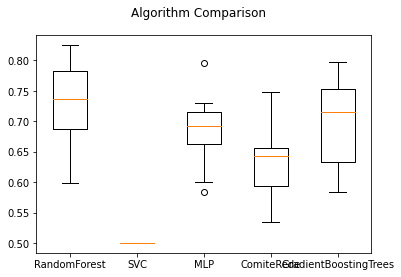

In [25]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Resultados finais de cada arquitetura

In [26]:
from sklearn.metrics import roc_auc_score

RandomForest
AUC RandomForest: Treinamento 0.9174418345649779
AUC RandomForest: Teste 0.7646270396270396
Classification report:
               precision    recall  f1-score   support

           1       0.92      0.99      0.95       715
           2       0.58      0.19      0.29        72

    accuracy                           0.91       787
   macro avg       0.75      0.59      0.62       787
weighted avg       0.89      0.91      0.89       787



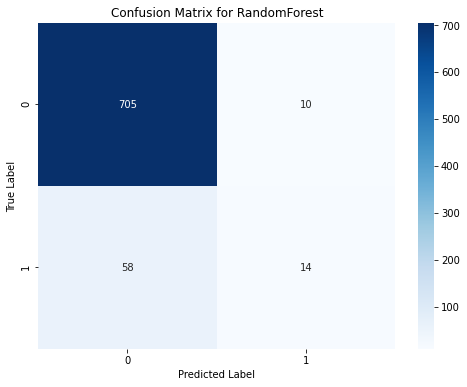



SVC
AUC SVC: Treinamento 0.0
AUC SVC: Teste 0.5
Classification report:
               precision    recall  f1-score   support

           1       0.91      1.00      0.95       715
           2       0.00      0.00      0.00        72

    accuracy                           0.91       787
   macro avg       0.45      0.50      0.48       787
weighted avg       0.83      0.91      0.86       787



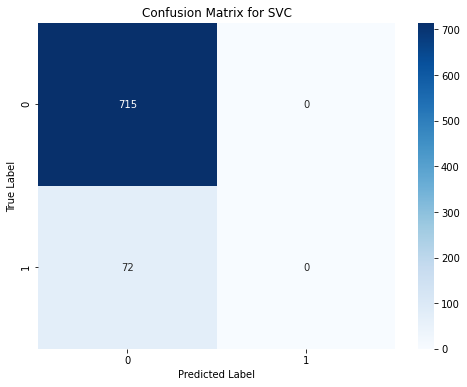



MLP
AUC MLP: Treinamento 0.6878307920848062
AUC MLP: Teste 0.7182206682206682
Classification report:
               precision    recall  f1-score   support

           1       0.91      1.00      0.95       715
           2       0.00      0.00      0.00        72

    accuracy                           0.91       787
   macro avg       0.45      0.50      0.48       787
weighted avg       0.83      0.91      0.86       787



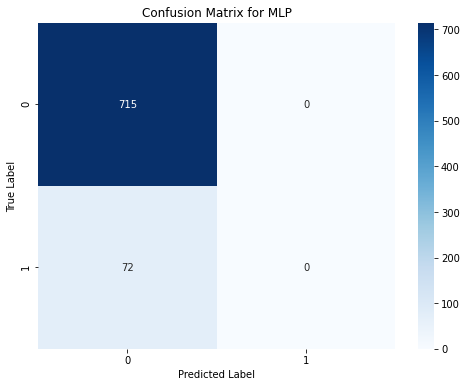



ComiteRede
AUC ComiteRede: Treinamento 0.6325969738039227
AUC ComiteRede: Teste 0.6210470085470086
Classification report:
               precision    recall  f1-score   support

           1       0.91      1.00      0.95       715
           2       0.00      0.00      0.00        72

    accuracy                           0.91       787
   macro avg       0.45      0.50      0.48       787
weighted avg       0.83      0.91      0.86       787



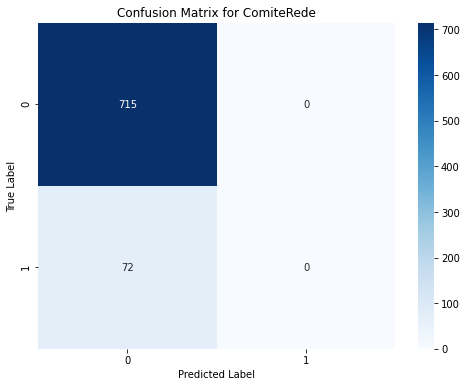



GradientBoostingTrees
AUC GradientBoostingTrees: Treinamento 0.9654991030383612
AUC GradientBoostingTrees: Teste 0.7706682206682206
Classification report:
               precision    recall  f1-score   support

           1       0.93      0.97      0.95       715
           2       0.47      0.24      0.31        72

    accuracy                           0.91       787
   macro avg       0.70      0.60      0.63       787
weighted avg       0.89      0.91      0.89       787



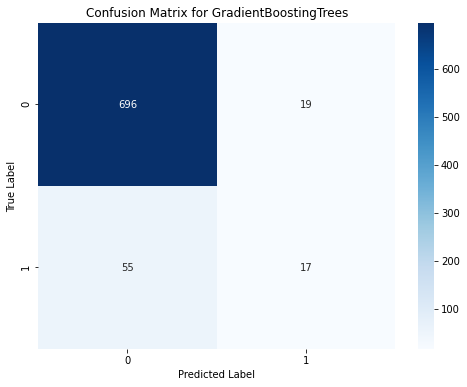

In [27]:
for name, model in models:
    # Treinamento
    model.fit(X_train, y_train)
    
    # Predição
    Y_test_prediction = model.predict(X_test)

    print(name)
    
    # Apresentação de resultados
    is_train = True
    for split in [(X_train, y_train), (X_test, y_test)]:
        probs = model.predict_proba(split[0])[:, 1]
        auc_roc = roc_auc_score(split[1], probs)
        if is_train:
            print(f"AUC {name}: Treinamento", auc_roc)
            is_train=False
        else:
            print(f"AUC {name}: Teste", auc_roc)

    print("Classification report:\n", classification_report(y_test, Y_test_prediction))
    
    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, Y_test_prediction), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("\n")

# Conclusão

Em suma, a análise foi realizada para cinco diferentes modelos de machine learning: RandomForest, SVC, MLP, ComiteRede e GradientBoostingTrees, com foco na classificação entre 'homem' (male)(classe 1) e 'mulher' (female) (classe 2). O principal que aprendemos com cada modelo foi:  

- RandomForest:
    - Mostrou um desempenho superior no conjunto de treinamento com AUC de aproximadamente 0.92. Porém, sua performance no conjunto de teste foi de 0.76, indicando uma possível overfit.  
    - A acurácia geral foi de 0.91, com uma excelente precisão na predição de 'homens' (0.92), mas uma precisão moderada para 'mulheres' (0.58).  
    - No desempenho médio obtido por validação cruzada, o modelo obteve 0.7293 com um desvio padrão de 0.0644.  

 - SVC:
    - Não conseguiu aprender os padrões no conjunto de treinamento, apresentando AUC de 0.5, e um desempenho medíocre no conjunto de teste com AUC de 0.5.  
    - Não conseguiu prever corretamente 'mulheres', indicando uma precisão e recall de 0 para essa classe.  
    - O desempenho médio por validação cruzada foi de 0.5, com desvio padrão de 0. Simplesmente um overfit pesado.

 - MLP:
    - Obteve um desempenho moderado no conjunto de treinamento com AUC de aproximadamente 0.69 e uma performance similar no conjunto de teste com AUC de 0.72.  
    - Assim como o SVC, falhou em prever corretamente 'mulheres'.  
    - O desempenho médio por validação cruzada foi de 0.6859 com um desvio padrão de 0.0590.

 - ComiteRede:
    - A performance no conjunto de treinamento foi moderada com AUC de 0.63 e no conjunto de teste foi ligeiramente inferior com AUC de 0.62.  
    - Também falhou em prever corretamente 'mulheres'.  
    - O desempenho médio por validação cruzada foi de 0.6329 com um desvio padrão de 0.0556.

 - GradientBoostingTrees:
    - Apresentou um excelente desempenho no conjunto de treinamento com AUC de aproximadamente 0.97, mas uma performance no conjunto de teste de 0.77, indicando, assim como RandomForest, uma possível overfit.  
    - A acurácia geral foi de 0.91, com uma excelente precisão na predição de 'homens' (0.93) e uma precisão aceitável para 'mulheres' (0.47).  
    - O desempenho médio por validação cruzada foi de 0.6980 com um desvio padrão de 0.0723.

**Com base no desempenho médio obtido pela validação cruzada, o modelo RandomForest se firma como o modelo mais promissor, com um score de 0.72. O GradientBoostingTrees também apresenta um desempenho competitivo com score de 0.6980.**